In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,
                                     Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf




#TensorFlow/Keras – do budowy i trenowania sieci
#ImageDataGenerator – do ładowania i augmentacji obrazów 
#Matplotlib/Numpy – do wizualizacji i manipulacji danymi

2025-07-27 09:58:43.479735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753610323.853577      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753610323.963252      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Klasy: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'T

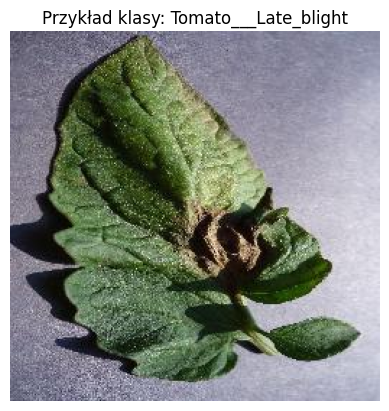

In [2]:
import cv2
import os
from matplotlib import pyplot as plt

folder_path_train = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

# Lista podfolderów (klas)
classes = os.listdir(folder_path_train)
print("Klasy:", classes)

# Wczytanie przykładowego obrazu z pierwszej klasy
first_class = classes[0]
image_files = os.listdir(os.path.join(folder_path_train, first_class))

# Wczytanie pierwszego obrazu z tej klasy
img_path = os.path.join(folder_path_train, first_class, image_files[0])
image = cv2.imread(img_path)  # wczytuje obraz w BGR
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # konwersja do RGB do wyświetlania

# Wyświetlenie obrazu
plt.imshow(image_rgb)
plt.title(f"Przykład klasy: {first_class}")
plt.axis('off')
plt.show()


In [3]:
base_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/valid"
#test_dir = f"{base_dir}/test"

img_size = (224, 224)
batch_size = 64

In [4]:
# Czyszczenie niepotrzebnych plików (technicznych) zapisywanych automatycznie przez Jupyter Notebook
import shutil
checkpoint_path = os.path.join(base_dir, '.ipynb_checkpoints')
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)

In [5]:
# Augmentacja i normalizacja dla treningu
train_datagen = ImageDataGenerator(
    rescale = 1./255, #Przeskalowuje piksele z zakresu [0, 255] do [0, 1]
    rotation_range = 20, #Losowy obrót obrazu w zakresie do ±20 stopni
    width_shift_range = 0.1, #Przesunięcie obrazu w poziomie o max 10% szerokości
    height_shift_range = 0.1, #Przesunięcie obrazu w pionie o max 10% wysokości
    brightness_range = [0.8, 1.2],
    zoom_range = 0.1, #Losowe powiększenie lub zmniejszenie obrazu
    horizontal_flip = True, #Odbicie lustrzane w poziomie
    fill_mode='nearest' #Jak wypełniać puste piksele powstałe po transformacjach (np. obrotach)
)

# Tylko normalizacja dla walidacji i testu
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True #mieszaj obrazy, kolejność zmienia się w każdej epoce.
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

#test_generator = val_test_datagen.flow_from_directory(
#    test_dir,
#    target_size=img_size,
#    batch_size=batch_size,
#    class_mode='categorical',
#    shuffle=False
#)

#automatycznie wczytuje obrazy z dysku,
#przypisuje etykiety na podstawie nazw folderów (np. Apple__Apple_scab → 0, Apple__Black_rot → 1, ... , 'Tomato___healthy' → 37),
#przygotowuje batch’e (partie danych) do uczenia,
#umożliwia podział danych (np. na trening i walidację),
#może też stosować augmentację i normalizację, jeśli była wcześniej zdefiniowana w ImageData

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [7]:
print("Klasy:", train_generator.class_indices)

# Przykładowy batch
images, labels = next(train_generator)
print("Shape obrazów:", images.shape)
print("Shape etykiet:", labels.shape)

Klasy: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 

In [8]:


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(38, activation='softmax')  # 38 klas
])



#Dwie warstwy konwolucyjne z aktywacją ReLU i max pooling.
#Warstwa Flatten spłaszcza dane.
#Dwie warstwy gęste (Dense) – ostatnia ma wyjście softmax bo 38 klas.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753610371.925182      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753610371.925978      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
# Kompilacja modelu

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#przygotowuje model do trenowania – określa sposób uczenia się i ewaluacji.

#Podgląd modelu
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,965,862 (45.65 MB)

 Trainable params: 11,965,862 (45.65 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras import callbacks
# Early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#monitoruje jakość modelu na zbiorze walidacyjnym (val_loss),
#przerywa uczenie, jeśli jakość nie poprawia się przez określoną liczbę epok (patience=3),
# przywraca najlepsze wagi, które model miał w czasie, gdy val_loss był najniższy

In [11]:
 #Trenowanie modelu 
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1753610379.027031      77 service.cc:148] XLA service 0x7b3c5c005e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753610379.028539      77 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753610379.028566      77 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753610379.373587      77 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1099 ━━━━━━━━━━━━━━━━━━━━ 1:18 71ms/step - accuracy: 0.0391 - loss: 9.7188  

I0000 00:00:1753610386.312557      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1482s 1s/step - accuracy: 0.2166 - loss: 3.1179 - val_accuracy: 0.6505 - val_loss: 1.1955
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1078s 981ms/step - accuracy: 0.5391 - loss: 1.5355 - val_accuracy: 0.7293 - val_loss: 0.8792
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1062s 967ms/step - accuracy: 0.6328 - loss: 1.1903 - val_accuracy: 0.7394 - val_loss: 0.8427
Epoch 4/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1059s 964ms/step - accuracy: 0.6871 - loss: 1.0113 - val_accuracy: 0.8152 - val_loss: 0.5958
Epoch 5/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1063s 967ms/step - accuracy: 0.7182 - loss: 0.9040 - val_accuracy: 0.8332 - val_loss: 0.5203


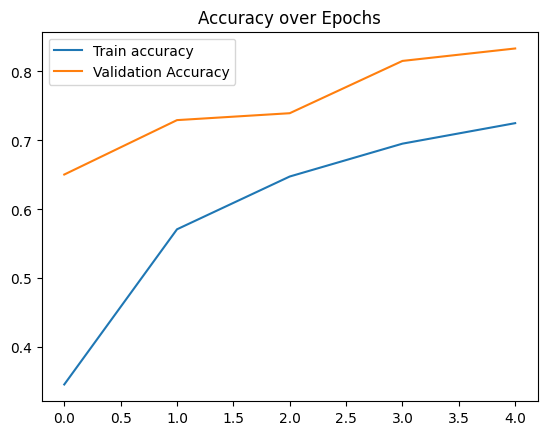

In [12]:
# Wizualizacja wyników
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [13]:
model.save("custom_cnn_model.h5")
import pickle

with open("train_history.pkl", "wb") as f:
    pickle.dump(history.history, f) #zapis

with open("train_history.pkl", "rb") as f: #załadowanie
    loaded_history = pickle.load(f)

### Top-1 Accuracy
 - To odsetek przypadków, w których najwyżej oceniona (najpewniejsza) klasa przewidziana przez model jest poprawna.

 - Najprostsza i najbardziej intuicyjna metryka dla klasyfikacji wieloklasowej.

 - Np. jeśli model trafnie przewidzi klasę na pierwszym miejscu, to jest to poprawna predykcja.

 ### Top-5 Accuracy
 - Sprawdza, czy prawdziwa klasa znajduje się wśród 5 najbardziej prawdopodobnych klas przewidzianych przez model.

 - Popularna w klasyfikacji obrazów z wieloma klasami (np. ImageNet), gdzie wiele klas jest podobnych.

 - Bardziej "wyrozumiała" niż Top-1, pokazuje, czy model w ogóle dobrze zawęził listę kandydatów.


 ### Precision (precyzja)
 - Ile spośród przewidzianych pozytywnych przypadków jest faktycznie pozytywne.

 - Wzór:

$$Precision = \frac{TP}{TP + FP}$$
 
 - Ważna, gdy koszt fałszywych alarmów (False Positives) jest wysoki.

### Recall (czułość)
 - Ile spośród faktycznie pozytywnych przypadków model poprawnie wykrył.

- Wzór:
$$Recall = \frac{TP}{TP + FN}$$
 
 - Ważna, gdy istotne jest, by nie pominąć żadnego prawdziwego przypadku (minimalizacja False Negatives).

### F1-score
 - Harmoniczna średnia precyzji i recall, łączy oba aspekty w jedną metrykę.

 - Wzór:
 $$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$

 
 - Używana, gdy trzeba zrównoważyć precyzję i recall.

In [14]:
# Metryk klasyfikacji: Top-1/Top-5 accuracy, precision, recall, F1-score

from sklearn.metrics import classification_report, accuracy_score, top_k_accuracy_score

# Pobierz prawdziwe etykiety i predykcje (softmax)
y_true = []
y_pred_probs = []

for X_batch, y_batch in val_generator:
    y_true.append(y_batch)
    preds = model.predict(X_batch)
    y_pred_probs.append(preds)
    if len(y_true)*val_generator.batch_size >= val_generator.n:
        break

y_true = np.vstack(y_true)  # shape: (num_samples, 38)
y_pred_probs = np.vstack(y_pred_probs)  # shape: (num_samples, 38)

# Zamień one-hot na indeksy klas
y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━

In [15]:
# Top-1 accuracy
top1_acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Top-1 Accuracy: {top1_acc:.4f}")

# Top-5 accuracy
top5_acc = top_k_accuracy_score(y_true_labels, y_pred_probs, k=5)
print(f"Top-5 Accuracy: {top5_acc:.4f}")

report = classification_report(y_true_labels, y_pred_labels, target_names=classes, zero_division=0)
print(report)

Top-1 Accuracy: 0.8332
Top-5 Accuracy: 0.9846
                                                    precision    recall  f1-score   support

                              Tomato___Late_blight       0.87      0.71      0.78       504
                                  Tomato___healthy       0.82      0.84      0.83       497
                                   Grape___healthy       0.88      0.88      0.88       440
          Orange___Haunglongbing_(Citrus_greening)       0.80      0.83      0.82       502
                                 Soybean___healthy       0.81      0.94      0.87       454
                           Squash___Powdery_mildew       0.93      0.91      0.92       421
                                  Potato___healthy       0.81      0.96      0.88       456
               Corn_(maize)___Northern_Leaf_Blight       0.85      0.80      0.82       410
                             Tomato___Early_blight       1.00      0.99      0.99       477
                       Tomato___S

In [16]:
# Testowanie predykcji na obrazach:

# Przykładowa ewaluacja
val_images, val_labels = next(val_generator)
predictions = model.predict(val_generator)

275/275 ━━━━━━━━━━━━━━━━━━━━ 52s 188ms/step


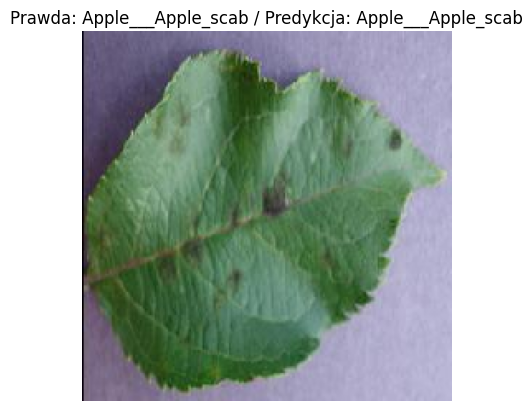

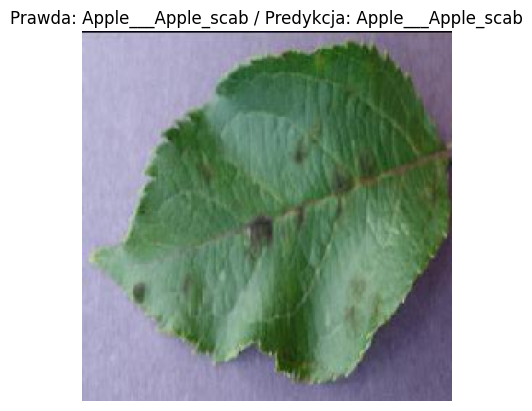

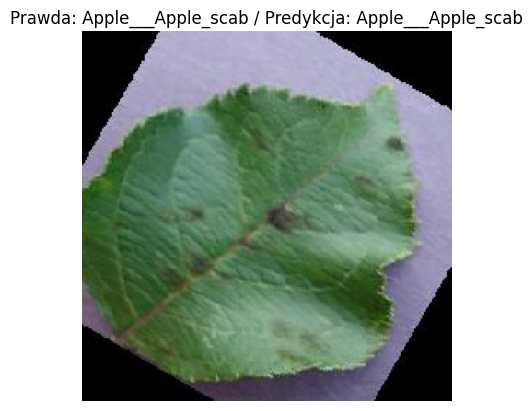

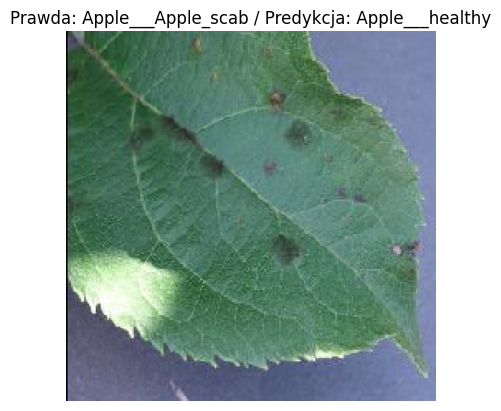

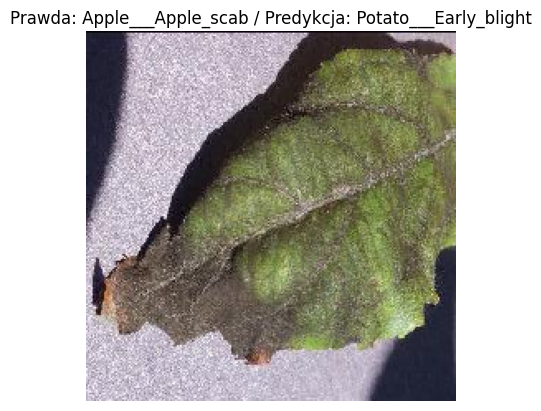

In [17]:
# Mapowanie indeksów klas na nazwy klas
class_names = list(train_generator.class_indices.keys())

# Wyświetlenie 5 przykładowych obrazów z predykcją i prawdziwą etykietą
for i in range(5):
    true_class = class_names[np.argmax(val_labels[i])]
    predicted_class = class_names[np.argmax(predictions[i])]
    
    plt.imshow(val_images[i])
    plt.title(f"Prawda: {true_class} / Predykcja: {predicted_class}")
    plt.axis('off')
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━

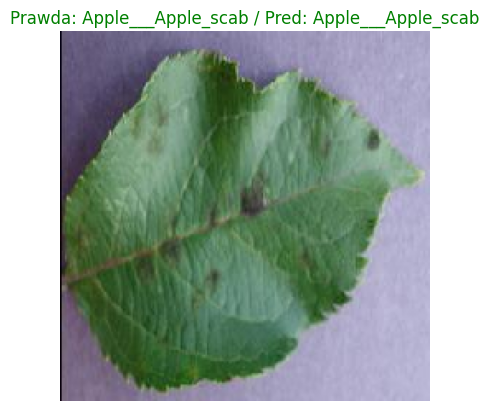

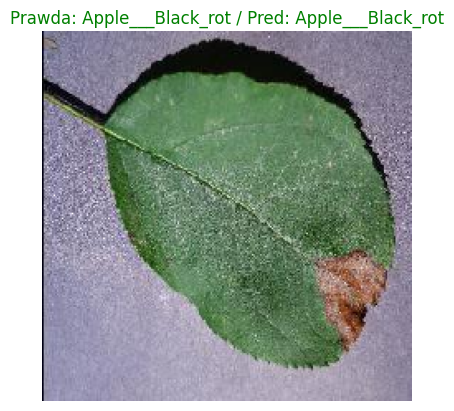

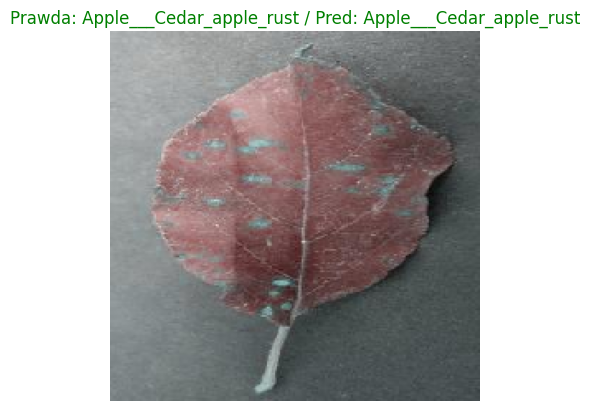

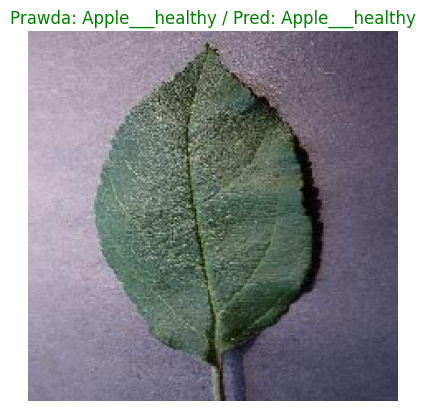

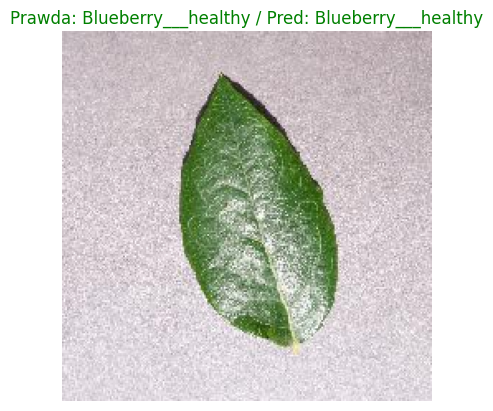

In [18]:
# Pokazuje losowe obrazy z różnych batch'y (np. 3 batch'e po 5 obrazów)
import random

# Zakładamy, że val_generator ma ustawione shuffle=False
val_generator.reset()  # żeby dane były w tej samej kolejności

# Zbierz po jednym obrazie z 5 różnych klas
found_classes = set()
selected_images = []
selected_labels = []
selected_predictions = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = model.predict(x_batch)

    for j in range(len(x_batch)):
        true_label_index = np.argmax(y_batch[j])
        class_name = class_names[true_label_index]

        if class_name not in found_classes:
            found_classes.add(class_name)
            selected_images.append(x_batch[j])
            selected_labels.append(true_label_index)
            selected_predictions.append(np.argmax(preds[j]))

        if len(found_classes) == 5:
            break
    if len(found_classes) == 5:
        break

# Wyświetlenie
for i in range(5):
    true_class = class_names[selected_labels[i]]
    predicted_class = class_names[selected_predictions[i]]

    plt.imshow(selected_images[i])
    plt.title(f"Prawda: {true_class} / Pred: {predicted_class}",
              color="green" if true_class == predicted_class else "red")
    plt.axis('off')
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


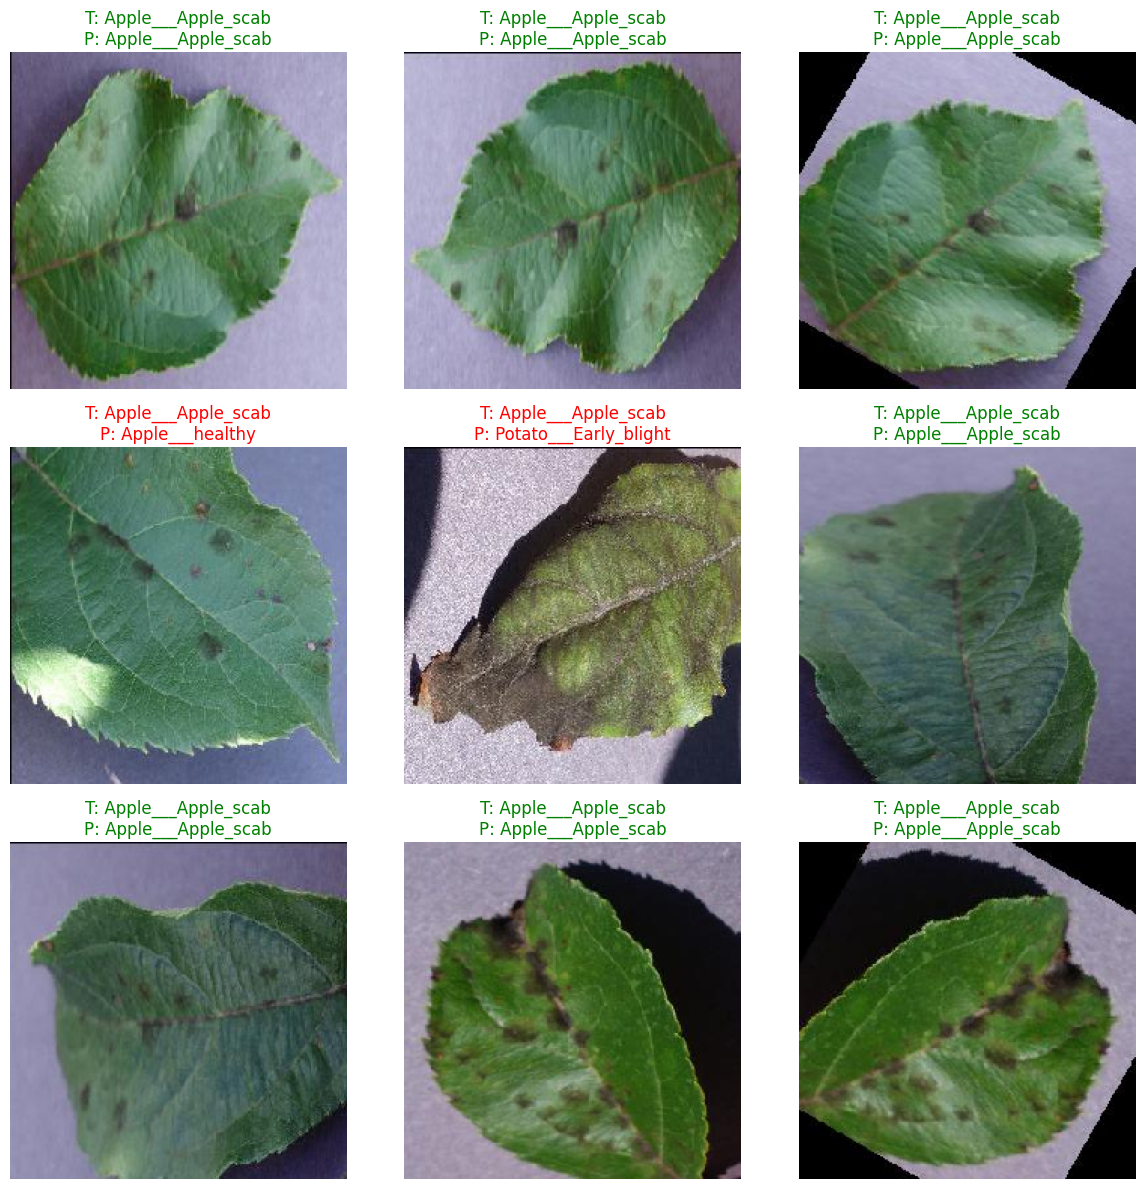

In [19]:
class_names = list(train_generator.class_indices.keys())

def show_predictions(model, generator):
    x, y = next(generator)
    preds = model.predict(x)

    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        true_label = class_names[np.argmax(y[i])]
        pred_label = class_names[np.argmax(preds[i])]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, val_generator)


In [20]:
#model.save('custom_cnn_model2.h5')
#from tensorflow.keras.models import load_model
#model = load_model('custom_cnn_model2.h5')

# Transfer Learning

Wykorzystać **Transfer Learning** (EfficientNet-B0 lub ResNet-50 z wagami ImageNet) z fine-tuningiem głowy klasyfikacyjnej.

Transfer Learning
* Base: EfficientNet-B0/ResNet-50 (wagami ImageNet), zamrożone warstwy dolne.
* Classification head: GlobalAveragePooling → Dropout(0.5) → Dense(38) → Softmax

Strategia treningu:
* Trening głowy przy zamrożonych wagach.
* Fine-tuning ostatnich bloków (10–20 % warstw).

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1103s 988ms/step - accuracy: 0.0441 - loss: 3.7005 - val_accuracy: 0.2284 - val_loss: 3.2535
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1092s 993ms/step - accuracy: 0.0922 - loss: 3.3832 - val_accuracy: 0.1679 - val_loss: 3.1172
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1099s 999ms/step - accuracy: 0.1129 - loss: 3.2869 - val_accuracy: 0.2261 - val_loss: 3.0013
Epoch 4/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1097s 998ms/step - accuracy: 0.1317 - loss: 3.2201 - val_accuracy: 0.2647 - val_loss: 2.9182
Epoch 5/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1103s 1s/step - accuracy: 0.1476 - loss: 3.1618 - val_accuracy: 0.2350 - val_loss: 2.8747


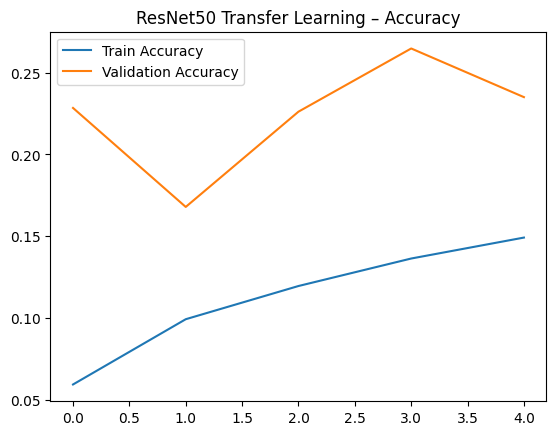

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step


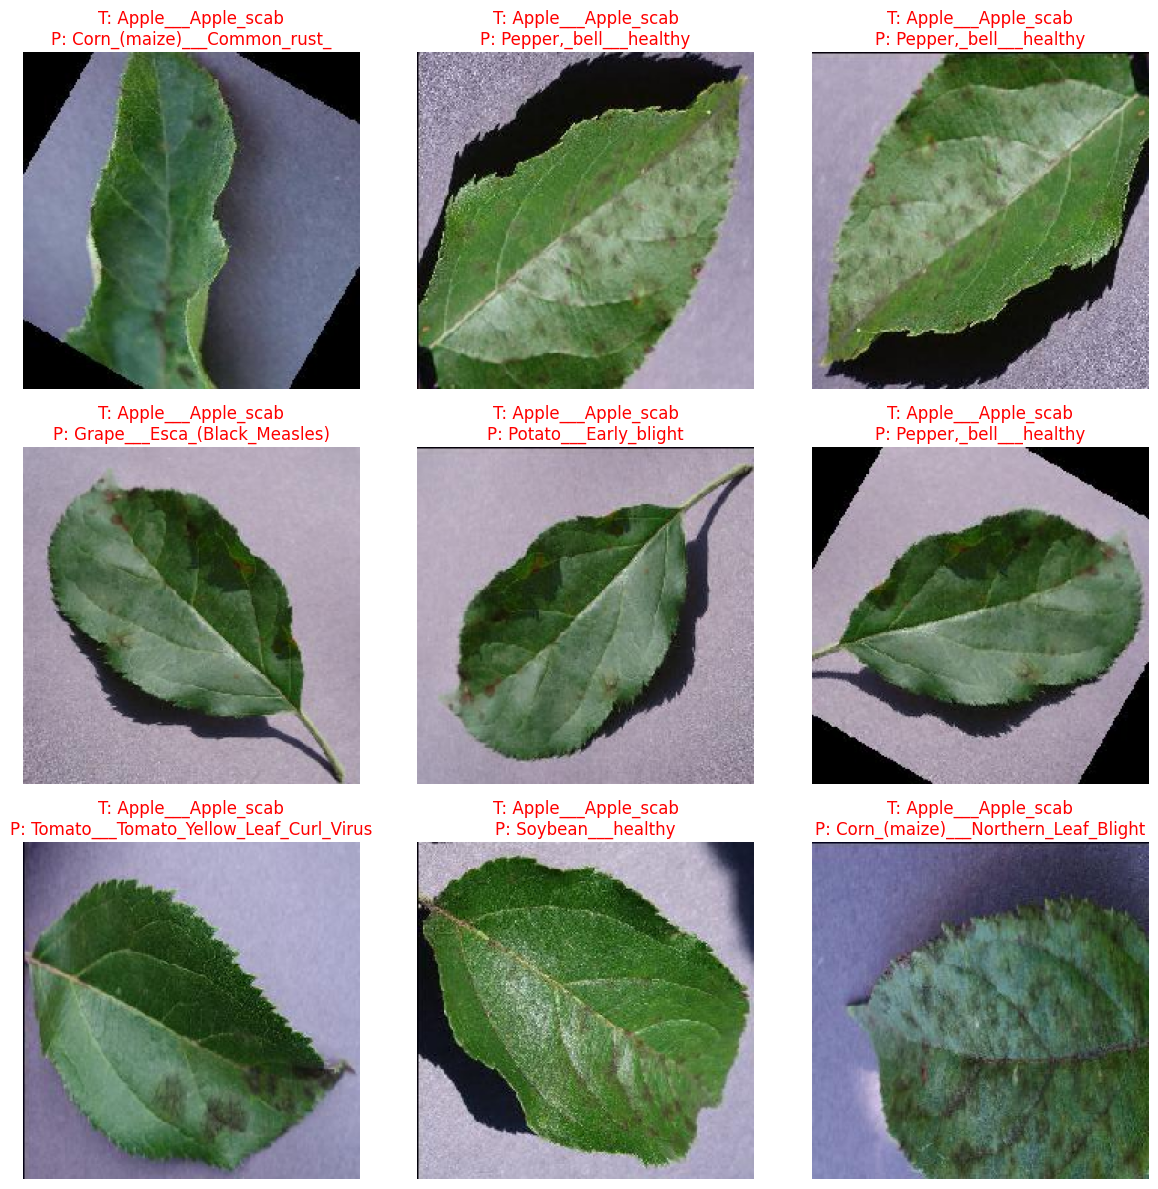

In [21]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

### ResNet50
# Wczytaj bazowy model z wagami ImageNet, bez górnych warstw (czyli bez klasyfikatora)
base_model = tf.keras.applications.ResNet50(
    include_top=False, #tylko część "bazowa" (bez ostatnich warstw klasyfikacyjnych) -  Zamrożenie wag – nie uczymy bazowych warstw na początku
    weights='imagenet', #załadowanie wag wytrenowanych na dużym zbiorze ImageNet
    input_shape=(224, 224, 3)
)

base_model.trainable = False #Zamraża wszystkie warstwy w bazowym modelu ResNet50

# Budowa modelu sieci neuronowej na bazie gotowego modelu ResNet50
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')
])

transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = transfer_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

#wizualizacja
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Transfer Learning – Accuracy')
plt.legend()
plt.show()

#Przykłądy klasyfikacji
show_predictions(transfer_model, val_generator)

In [22]:
### EfficientNet-B0
# Wczytaj bazowy model z wagami ImageNet, bez górnych warstw (czyli bez klasyfikatora)
base_model = EfficientNetB0(
    include_top=False, #tylko część "bazowa" (bez ostatnich warstw klasyfikacyjnych) -  Zamrożenie wag – nie uczymy bazowych warstw na początku
    weights='imagenet', #załadowanie wag wytrenowanych na dużym zbiorze ImageNet
    input_shape=(224, 224, 3)
)

# Zamrożenie wszystkich warstw bazowego modelu
base_model.trainable = False

# Dodanie własnej głowy klasyfikacyjnej
x = base_model.output
x = GlobalAveragePooling2D()(x) #zmniejsza dane 4D do 2D
x = Dropout(0.5)(x) #zapobiega naduczeniu (50% neuronów losowo wyłączane)
output = Dense(38, activation='softmax')(x) #warstwa wyjściowa dla 38 klas

model2 = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu (trening tylko głowy)
model2.compile(optimizer=Adam(learning_rate=1e-3), #Wysoki learning rate, bo głowa ma losowe wagi – chcemy, żeby szybko się nauczyła.
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trening tylko głowy (bazowy EfficientNet nie jest modyfikowany)
history = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

#  Odmrożenie ostatnich 10-20% warstw EfficientNet
# Ile warstw ma model?
total_layers = len(base_model.layers)
fine_tune_at = int(total_layers * 0.8)  # ostatnie 20%

#ostatnie warstwy bazowego modelu jako trenowalne (np. fine-tuning warstw wyższych, które mają bardziej ogólne cechy)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Kompilacja z niższym learning rate
model2.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning
history_fine = model2.fit( #Trening końcówki EfficientNet i głowy, żeby jeszcze lepiej dopasować do zbioru danych
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1128s 1s/step - accuracy: 0.0271 - loss: 3.6951 - val_accuracy: 0.0274 - val_loss: 3.6685
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1084s 986ms/step - accuracy: 0.0276 - loss: 3.6876 - val_accuracy: 0.0276 - val_loss: 3.6550
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1090s 992ms/step - accuracy: 0.0282 - loss: 3.6862 - val_accuracy: 0.0260 - val_loss: 3.6662
Epoch 4/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1094s 995ms/step - accuracy: 0.0258 - loss: 3.6831 - val_accuracy: 0.0267 - val_loss: 3.6644
Epoch 1/5


E0000 00:00:1753626236.538663      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753626236.681759      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753626237.089318      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753626237.233523      77 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 243/1099 ━━━━━━━━━━━━━━━━━━━━ 13:18 933ms/step - accuracy: 0.0268 - loss: 3.6996

E0000 00:00:1753626476.056079      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753626476.197600      80 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1158s 1s/step - accuracy: 0.0347 - loss: 3.6405 - val_accuracy: 0.0586 - val_loss: 3.4693
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1095s 996ms/step - accuracy: 0.0852 - loss: 3.3541 - val_accuracy: 0.0783 - val_loss: 3.5981
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1123s 1s/step - accuracy: 0.1340 - loss: 3.1105 - val_accuracy: 0.0631 - val_loss: 3.7714


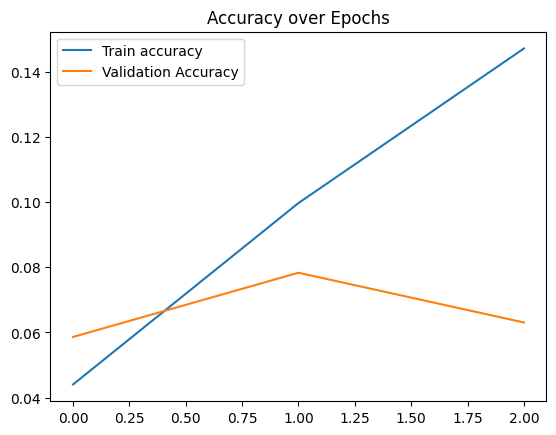

In [23]:
# Wizualizacja wyników
plt.plot(history_fine.history['accuracy'], label='Train accuracy')
plt.plot(history_fine.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

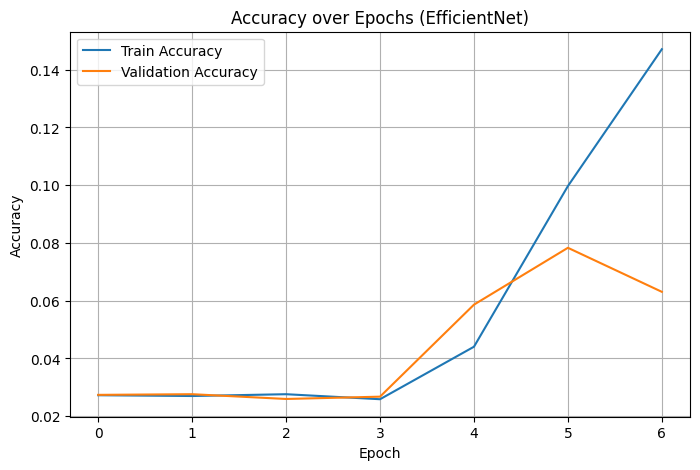

In [24]:
# Połączenie obu etapów treningu
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

# Wizualizacja
plt.figure(figsize=(8, 5))
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs (EfficientNet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Porównanie modeli

In [25]:
print(y_true.shape)

(17572, 38)


In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, top_k_accuracy_score

# Zbieranie prawdziwych etykiet i predykcji
y_true = []
y_pred_probs = []

for X_batch, y_batch in val_generator:
    y_true.append(y_batch)
    preds = model2.predict(X_batch)
    y_pred_probs.append(preds)
    if len(y_true) * val_generator.batch_size >= val_generator.n:
        break

# Łączenie wszystkich batchy
y_true = np.vstack(y_true)             # shape: (num_samples, 38)
y_pred_probs = np.vstack(y_pred_probs) # shape: (num_samples, 38)

# Konwersja z one-hot na indeksy klas
y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)



2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━

In [27]:
# Top-1 Accuracy
top1 = accuracy_score(y_true_labels, y_pred_labels)

# Top-5 Accuracy
top5 = top_k_accuracy_score(y_true_labels, y_pred_probs, k=5)

# Precision, Recall, F1-score (średnia ważona)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Wyświetlenie wyników
print("🔍 Wyniki dla EfficientNetB0 + fine-tuning:")
print(f"Top-1 Accuracy : {top1:.4f}")
print(f"Top-5 Accuracy : {top5:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1-score       : {f1:.4f}")



🔍 Wyniki dla EfficientNetB0 + fine-tuning:
Top-1 Accuracy : 0.0586
Top-5 Accuracy : 0.2779
Precision      : 0.0154
Recall         : 0.0586
F1-score       : 0.0192


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
